# `20180831c` - Trying a probe with linear transformator - process

In [3]:
#!/usr/bin/python
import spidev
import time
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import time
from pyUn0 import *
%matplotlib inline
import os
from scipy.signal import hilbert, resample
import cv2

Not loading RPi.GPIO as not on RPi
pyexiv2 does not exist on RPi


967682 483841.0 483840
Data acquired
2703 179
PyExiv not present


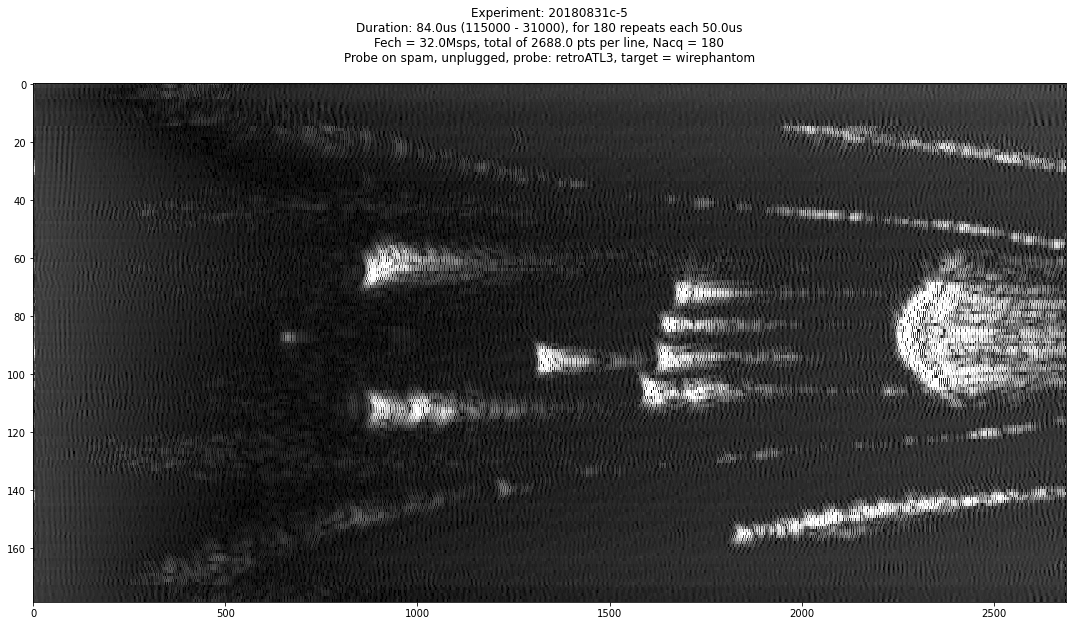

TypeError: slice indices must be integers or None or have an __index__ method

In [4]:
for MyDataFile in os.listdir("data/"):
    if MyDataFile.endswith(".json"):
        x = us_json()
        x.JSONprocessing("data/"+MyDataFile)
        CleanImage = x.mk2DArray()
        S = x.mkSpectrum(CleanImage)

In [5]:
CleanImage

array([[-1.375     ,  0.41015625,  0.3828125 , ...,  0.1171875 ,
         0.11328125,  0.        ],
       [ 0.11328125,  0.1171875 ,  0.125     , ...,  0.0625    ,
         0.19921875,  0.3125    ],
       [ 0.3671875 ,  0.28515625,  0.1953125 , ...,  0.2109375 ,
         0.        ,  0.        ],
       ...,
       [ 0.09765625,  0.109375  ,  0.125     , ...,  0.0625    ,
         0.        ,  0.        ],
       [ 0.09375   ,  0.10546875,  0.11328125, ...,  0.0703125 ,
         0.07421875,  0.078125  ],
       [ 0.0859375 ,  0.10546875,  0.1015625 , ...,  0.1171875 ,
         0.        ,  0.        ]])

In [6]:
np.savez("31c.npz",img=[CleanImage])

# Building clean image

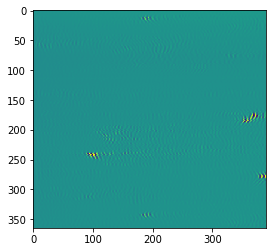

In [4]:
plt.imshow((CleanImage[:,10:400]))

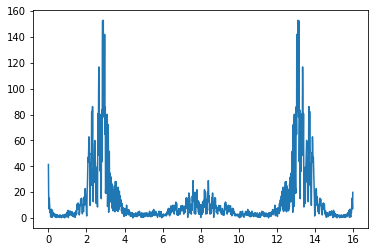

16.0

In [5]:
MV = np.argmax(np.var(CleanImage, axis=1))

#plt.plot(CleanImage[MV])
#plt.show()
L = len(CleanImage[MV])
f = [k*x.f/L for k in range(L)]

plt.plot(f, np.abs(np.fft.fft(CleanImage[MV])))
plt.show()

x.f

In [6]:
N,L = np.shape(CleanImage)

In [7]:
#%%time
HMatrix = []
for m in range(N):
    line = CleanImage[m]
    L = len(line)
    A = np.fft.fft(line)
    for k in range (L/2 + 1):
        if k < (L * x.fPiezo * 0.2 / x.f):
            A[k] = 0
            A[-k] = 0
        if k > (L * x.fPiezo *1.7 / x.f):
            A[k] = 0
            A[-k] = 0

    CleanImage[m] =  np.real(np.fft.ifft(A))
    HMatrix.append(resample(np.abs(hilbert(CleanImage[m])),1000))

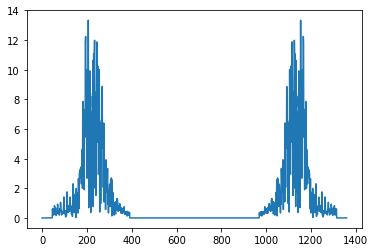

In [8]:
plt.plot(np.abs(A))
plt.show()

In [9]:
ProbeOffset = int(x.timings['t4'] *x.f / 1000)
CledImage = np.pad(CleanImage, ((0,0),(ProbeOffset,0)), 'constant')
HMatrixCld = np.pad(HMatrix, ((0,0),(ProbeOffset,0)), 'constant')
np.shape(HMatrix)

(365, 1000)

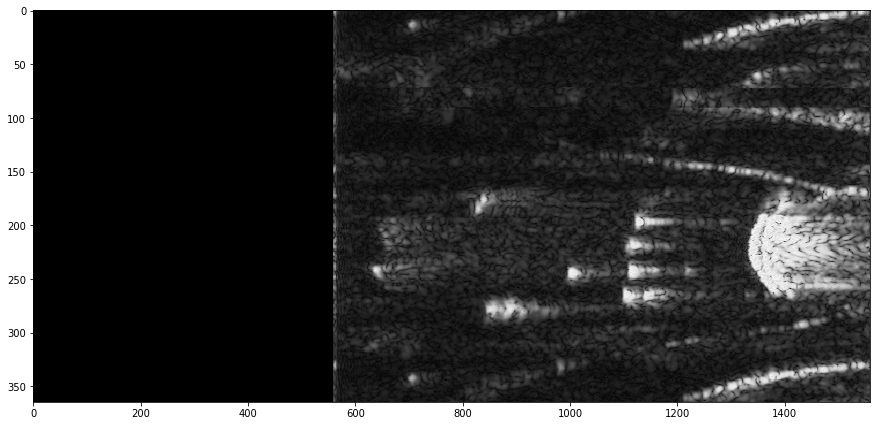

In [10]:
plt.figure(figsize = (15,15))
im = plt.imshow(np.sqrt(HMatrixCld), cmap='gray', aspect=1*(len(HMatrix[0])/len(HMatrix)), interpolation='nearest') 

In [11]:
%%time
import cv2

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.1 Âµs


In [12]:
n,l = np.shape(HMatrixCld)
print n,l

365 1560


maxRadius = 1560 pixels


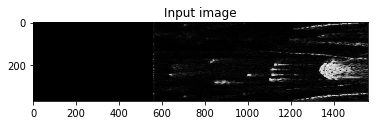

232.366216914 rows per radian
theta: [2.35619449019, 3.92699081699] radians
Padding 547 above and 547 below


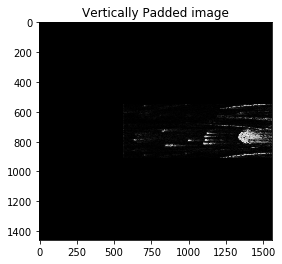

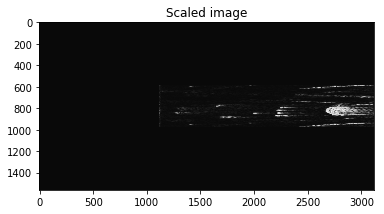

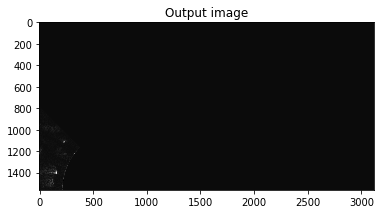

CPU times: user 2.52 s, sys: 2.68 s, total: 5.21 s
Wall time: 4.31 s


In [13]:
%%time
maxRadius = l
print("maxRadius = {} pixels".format(maxRadius))

plt.imshow(HMatrixCld, cmap='gray')
plt.title("Input image")
plt.show()

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = n / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, HMatrixCld, im_below))
plt.imshow(padded_image, cmap='gray')
plt.title("Vertically Padded image")
plt.show()

# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC) 
plt.imshow(scaled_image, cmap='gray')
plt.title("Scaled image")
plt.show()

# transform image
center = (int(scaled_image.shape[0]/2),int(scaled_image.shape[1])/2) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

In [14]:
im_in = np.asarray(HMatrix)

In [15]:
im_in.shape[0]

365

In [16]:
maxRadius = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(0.5* theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int(0.5* (2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius), dtype='uint16')
im_above = np.zeros((pad_above, maxRadius), dtype='uint16')

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)

maxRadius = 1000 pixels
232.366216914 rows per radian
theta: [2.35619449019, 3.92699081699] radians
Padding 273 above and 273 below


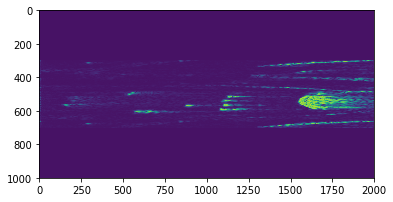

In [17]:
plt.imshow(scaled_image)
plt.show()

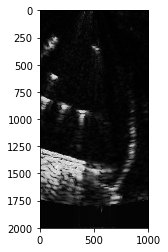

In [18]:
center = (2200, 500)
maxRadius = 2000
flags = cv2.WARP_INVERSE_MAP
dst = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(np.flipud(np.transpose(dst)), cmap='gray')